In [1]:
#!unzip "/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision"

# Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow and TensorFlow Hub. 

By following the worklow:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, 3 sets, X & y).
3. Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works and then increase it).
6. Save, sharing and reloading the model.

## Getting the workspace ready

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

#Check for GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.4.1
Hub version: 0.11.0
GPU available


## Getting the data ready (turning into Tensors)

In [3]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d4dbe4468560bb227aac6627237ab9ec  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


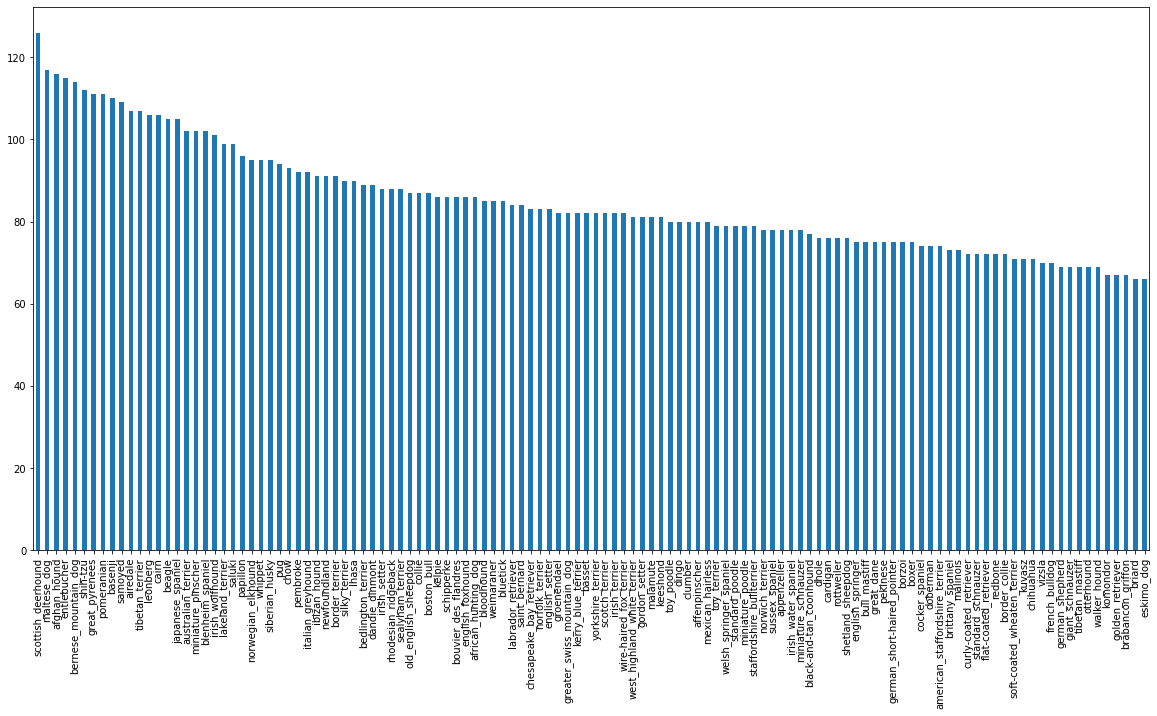

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

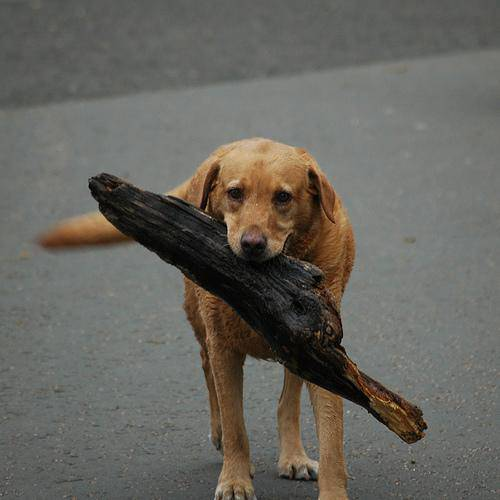

In [7]:
# View an image
from IPython.display import Image
Image("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels

Listing all the images file pathnames.

In [8]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 

In [9]:
import os
os.listdir("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/")[:10]

['e073b458a33cbfe9b733764a1246f52e.jpg',
 'e79a5176fe0322a36d09f057d64aec54.jpg',
 'dd5a3c84fb3c388ecf0b4da61eaef352.jpg',
 'deb88665ad11440ea55963b57e9ad79c.jpg',
 'e2379f60b78b0939a84ebd641ff3bb4a.jpg',
 'df464ebe3f311744241cb3d9258a5000.jpg',
 'dee5db7f0834ca1db80615a9d5fb6334.jpg',
 'e47a26a0b4510b25250f654577207ed3.jpg',
 'dd126e42b474c3831f8fda33052428c1.jpg',
 'e0c2b69fc53eeb74dfbf31a1ce54b11a.jpg']

In [10]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/")) == len(filenames):
  print("Filenames match")
else:
  print("Filenames do not match")

Filenames match


In [11]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
len(labels)

10222

In [13]:
# Check if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("match")
else:
  print("Do not match")

match


In [14]:
# Find the unique label values and turn it to numbers
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [15]:
# Turn a label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

### Creating own validation set

Kaggle does not provide one for this Data

In [18]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [19]:
len(filenames)

10222

Start experimenting with ~1000 images and increase as needed

In [20]:
# Set number of images for experimentation
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [21]:
# Splitting data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                   test_size=0.2,
                                                   random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocessing images (turning images into Tensor)

The labels are in numeric format but the images are still just file paths, they have to be in the form of Tensors.
A Tensor is a way to represent information in numbers, it can be thought of as a combination of NumPy arrays, except 
with the special ability to be used on a GPU. The function to process the images will do the following:

  1. Takes an image filename as input.
  2. Uses TensorFlow to read the file and save it to a variable, image.
  3. Turn the image (a jpeg file) into Tensors.
  4. Resize the image to be of shape (224, 224).
  5. Return the modified image.

In [22]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [23]:
tf.constant(image) [:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [24]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Creating data batches 

In [25]:
# Function that returns a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [26]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  if test_data:
    print("Creating test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

    #If the data is a valid dataset, no need to shuffle it
  elif valid_data:
    print("Creating validation data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    #If the data is a dataset, it's shuffle
    print("Creating training data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))
    # Create (image, label) tuples 
    data = data.map(get_image_label)
    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [27]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches
Creating validation data batches


In [28]:
# Checking the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

Now the data is in batches, in Tensor pairs of (images, labels) ready for use on a GPU.

But having the data in batches is hard to understand, for that a function that helps visualize is in order.

### Visualizing data batches

In [29]:
import matplotlib.pyplot as plt

# Function for viewing images in data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

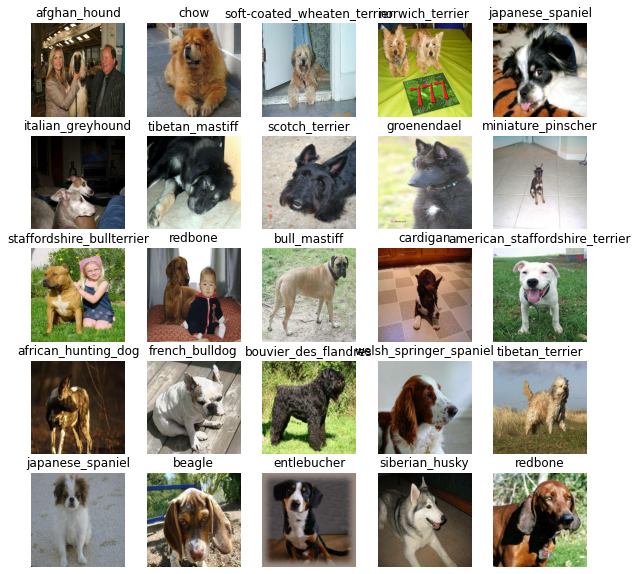

In [30]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

### Creating and training a model

An existing model from TensorFlow Hub will be used, and thus transfer learning as well.

Before it is build there are things to be define:

  * The input shape (images, in Tensor form) to the model.
  * The output shape (image labels, with Tensor form) of the model.
  * The URL of the model that will be used.

In [31]:
#Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

#Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

#Setup model URL from Tensor Flow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now that the inputs, outputs and model are ready it is time to put them together using the Keras API.

The function needed for this exercise has to do the following:

  * Takes the input shape, output shape and the model's URL as parameters.
  * Defines the layers in a Keras model in a sequential fashin ("do this first, then this, then that")
  * Compiles the model (explain how should be evaluated and improved)
  * Builds the model (what kind of input shape it'll be getting)
  * Returns a model.

In [32]:
# function that builds a Keras model
def create_model (input_shape = INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), #The model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # Support telling the model how to improve its guesses
      metrics=["accuracy"] # What needs to improve
  )

  # Build the model
  model.build(INPUT_SHAPE) # Letting the model know what kind of inputs it will be getting

  return model

In this exercise the sequential API of Keras has been used instead of the functional to set up the model layers. Why? The Keras documentation states the functional API is the way to go for defining complex models but the sequential API (linear stack of layers) is perfectly fine for getting started. 

The first layer used is the model from TensorFlow Hub, so the first layer is actually an entire model. This input layer takes in the images and finds patterns in them based on the patterns the Hub model has found.

The next layer is the output layer of the model. It brings all of the information discovered in the input layer together and outputs it in the desired shape, 120 (the number of unique labels).

The activation="softmax" parameter tells the output layer, that a probability value should be assign to each of the 120 labels somewhere between 0 & 1. The higher the value, the more the model believes the input image should have that label. If this was a binary classification problem the activation="sigmoid" will have been used.

In [33]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving. 

The two callbacks used in this exercise are TensorBoard callback and an Early Stopping callback.

### TensorBoard
TensorBoard helps to privide a visual way to monitor the progress of the model during and after training. It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

In [34]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [35]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Helps prevent overfitting by stopping a model when a certain evaluation metric stop improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (does not generaliza).

["Keep finding patterns until the quality of those patterns starts to go down"]

In [36]:
# Create early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)
# Stops after 3 rounds of no improvements

## Training a model (on a subset of data)

The first model is only going to be trained on 1000 images, 10% of the total data. It is done this way to make sure evetything is working.

The final parameter to be define before training is NUM_EPOCHS (number of epochs).

NUM_EPOCHS defines how many passes of the data the model should perform. A pass is equivalent to the model trying to find patterns in each dog image and see which patterns relate to each label.

What is good value for NUM_EPOCHS?

Hard to say, could be 10 to start or 100, that is the reason to set up the early stopping callback, it means that if the NUM_EPOCHS is set to 100 but the model stops improving after 22 epochs, it will stop training.

In [37]:
# How many rounds should the model look through the data?
NUM_EPOCHS = 10 #@param {type:"slider", min:10, max:100, step:10}

Now with GPU running and NUM_EPOCHS setup it's time to make a function that trins a model:

  * Create a model using create_model().
  * Setup a TensorBoard callback using create_tensorboard_callback() (it's done here to create a log directory of the current date and time).
  * Call the fit() function on the model passing it the training data, validation data, number of epochs to train for and the callbacks to be use.
  * Return the fitted model. 

In [40]:
# Function to train and return a trained model
def train_model():
  model = create_model()

  tensorboard = create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  return model

In [41]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 208s 7s/step - loss: 4.9581 - accuracy: 0.0406 - val_loss: 3.3298 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 4s 155ms/step - loss: 1.8383 - accuracy: 0.6407 - val_loss: 2.1258 - val_accuracy: 0.4700
Epoch 3/100
25/25 [==============================] - 4s 154ms/step - loss: 0.5718 - accuracy: 0.9435 - val_loss: 1.6622 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 4s 151ms/step - loss: 0.2449 - accuracy: 0.9948 - val_loss: 1.4754 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 4s 151ms/step - loss: 0.1403 - accuracy: 0.9982 - val_loss: 1.4031 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 4s 150ms/step - loss: 0.0935 - accuracy: 0.9988 - val_loss: 1.3471 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================]